In [ ]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# # sns.set_style(style='whitegrid')
# device_num = 0
# torch.cuda.set_device(device_num)

### Загрузим датасет

На занятии мы познакомимся с датасетом Симпсонов! Там собраны знакомые многим персонажи знаменитого мультфильма для решения задачи классификации.

In [ ]:
# загрузим датасет со своего Google Drive

# предварительно необходимо скачать датасет с kaggle: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
# создать zip-архивы из папок simpsons_dataset и kaggle_simpson_testset
# и загрузить на свой google drive в папку netology_dl_sem

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!mkdir -p data

!cp drive/MyDrive/netology_dl_sem/test.zip data/
!cp drive/MyDrive/netology_dl_sem/train.zip data/

!unzip -o -qq data/test.zip -d data/
!unzip -o -qq data/train.zip -d data/
!rm -rf data/simpsons_dataset/simpsons_dataset

Все данные теперь находятся в папке `data`.

Тестовые данные (`kaggle_simpson_testset/`) сегодня не пригодятся.

Структура трейн данных (`simpsons_dataset/`) следующая:


 \\
-- class_name_0 \\
---- img_0 \\
---- img_1 \\
---- ... \\
---- img_n \\
... \\
-- class_name_k \\
---- img_0 \\
---- img_1 \\
---- ... \\
---- img_m \\


Т.е. название папки -- имя класса (персонажа из Симпсонов), изображения в ней относятся к этому классу.

In [ ]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "data/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


В случае описанного выше строения хранящихся данных для создания датасета очень удобен `ImageFolder`.

Хоть авторы библиотеки это и не задумывали, но аргумент `is_valid_file` нам пригодился для разбиения на `train` и `val`.

In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [ ]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


Посмотрим на изображения из `val` и `train`

In [ ]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

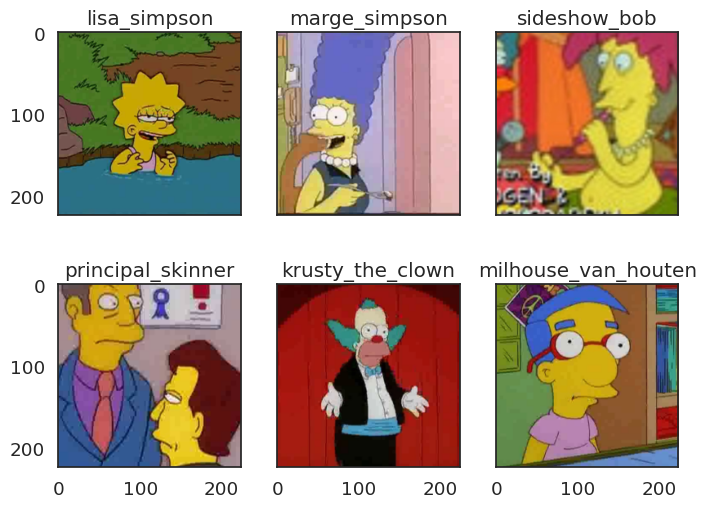

In [ ]:
show_images(val_dataset)

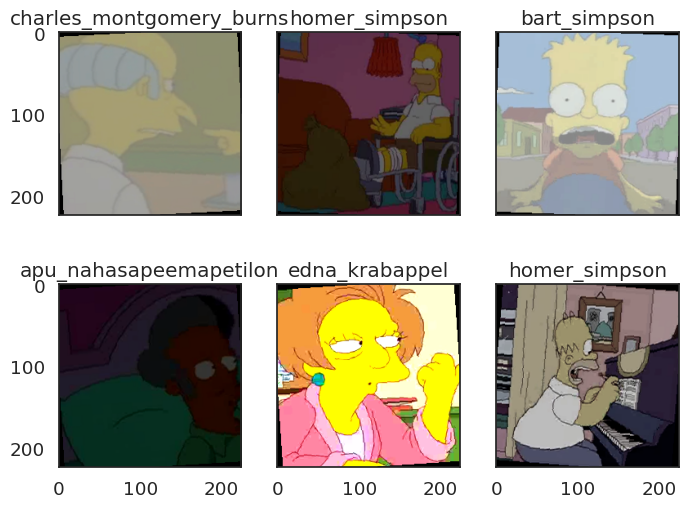

In [ ]:
show_images(train_dataset)

Невооруженным взглядом видно, что картинки из `train` выглядят немного изменёнными по сравнению с `val`. Опишем по пунктам, почему так происходит.

1. К `train` применялись дополнительные аугментации `ColorJitter` и `RandomAffine`, чтобы увеличить размер датасета и обобщающую способность сети.
2. К `val` никакие меняющие изображение аугментации не применялись, т.к. замерять метрику качества необходимо на настоящих данных.

**Создадим DataLoader-ы и функции для обучения**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

In [ ]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

# Домашнее задание

# 3. Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.

In [ ]:
from torchvision.models import efficientnet_b0

### Обучение `EfficientNet B0` с нуля

Epoch 10 of 10 took 214.157s
  training loss (in-iteration): 	1.567075
  validation loss (in-iteration): 	1.180599
  training accuracy: 			58.21 %
  validation accuracy: 			68.47 %


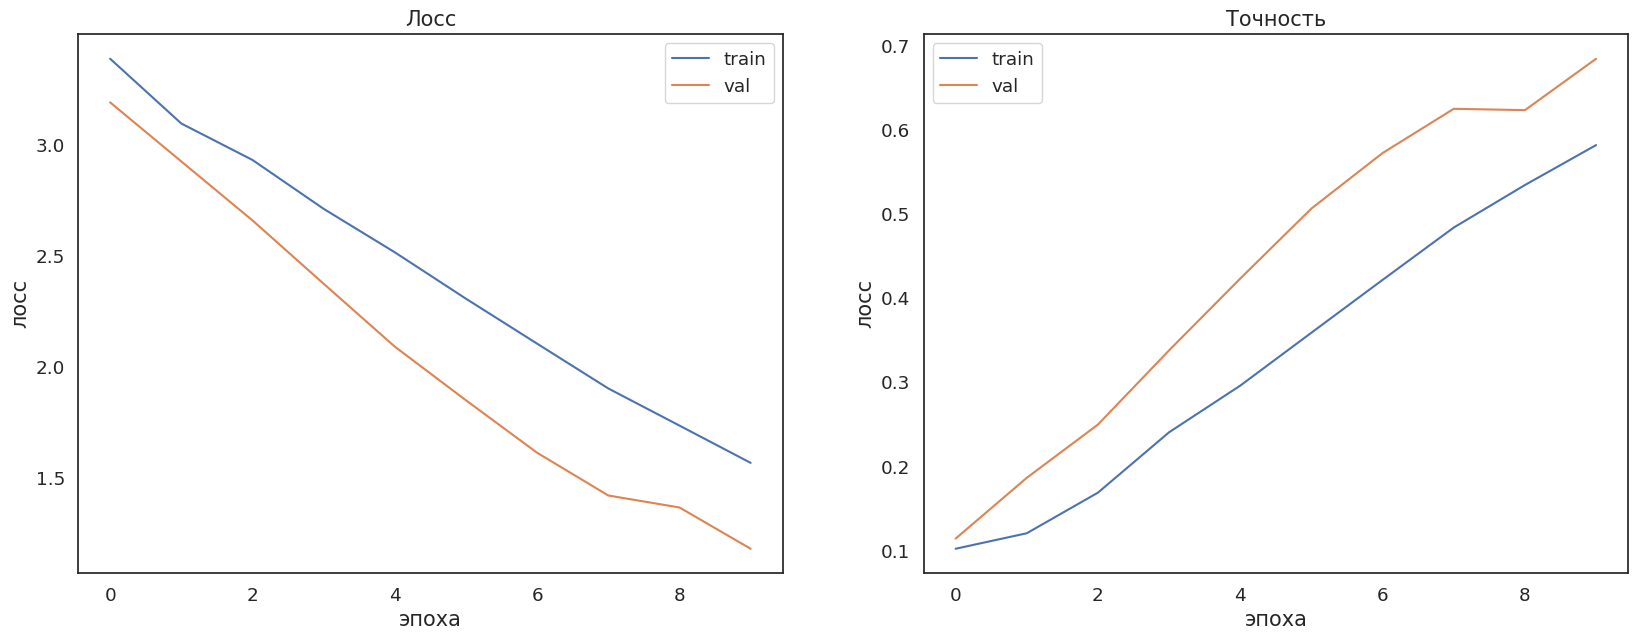

In [ ]:
model = efficientnet_b0(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

### Использование `EfficientNet B0` как `Feature Extractor`

In [ ]:
# Без этой ячейки с кодом вызов метод efficientnet_b0(pretrained=True) дает ошибку

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_b0(weights="DEFAULT")

Epoch 10 of 10 took 159.014s
  training loss (in-iteration): 	1.976860
  validation loss (in-iteration): 	1.646684
  training accuracy: 			53.33 %
  validation accuracy: 			64.66 %


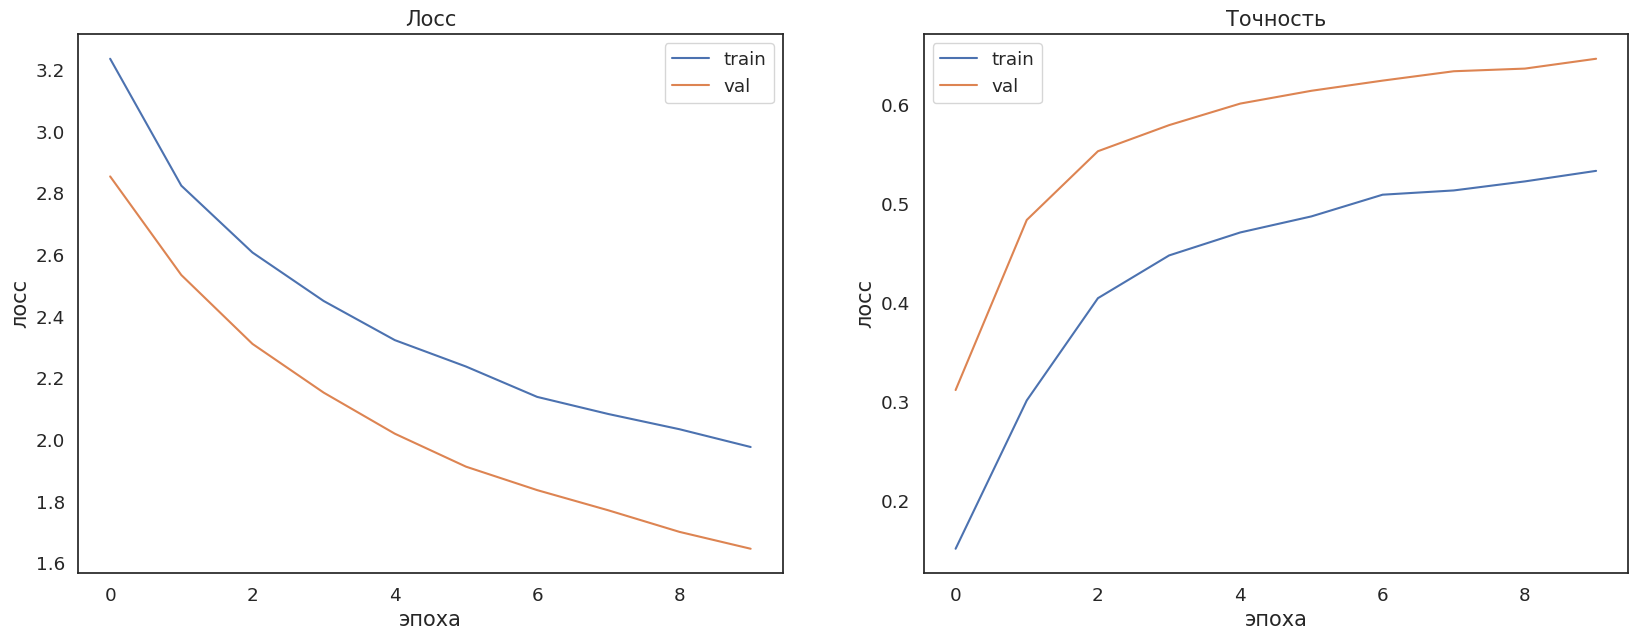

In [ ]:
model = efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

### Использование `EfficientNet B0` для `Fine Tuning`

Epoch 10 of 10 took 209.224s
  training loss (in-iteration): 	0.264356
  validation loss (in-iteration): 	0.215013
  training accuracy: 			93.10 %
  validation accuracy: 			94.30 %


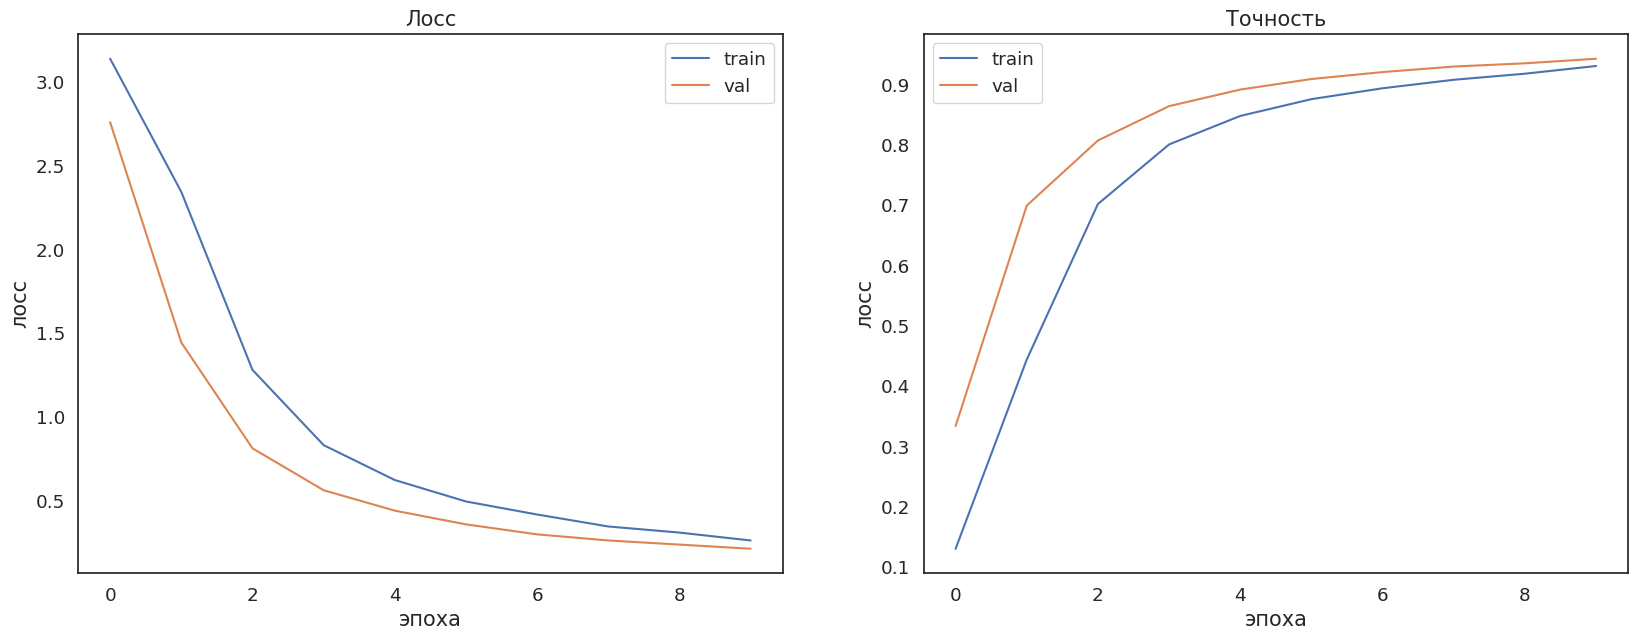

In [ ]:
model = nn.Sequential()
model.add_module('efficientnet', efficientnet_b0(pretrained=True))
model.add_module('relu_1', nn.ReLU())
model.add_module('fc_1', nn.Linear(1000, 512))
model.add_module('relu_2', nn.ReLU())
model.add_module('fc_2', nn.Linear(512, 42))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

## Выводы
При обучении EfficientNet B0 разными методами Transfer Learning в течение 10 эпох, результаты в целом получились похожими на те, что были получены на практическом занятии на архетиктуре ResNet 18.

 - При обучении с нуля точность на валидации достигла 68%, и, судя по графикам оптимизации, еще не вышла на плато, что может говорить о большем потенциале такого метода на этой архитектуре в сравнении со следующим методом.
 - Второй метод (использование EfficientNet B0 в качестве Feature Extractor) не дал прироста в качестве по истечении 10 эпох. Точность на валидации приблизилась к 65% и уже практически вышла на плато. Такая же ситуация наблюдалась и на приктике при обучении ResNet 18.
 - Лучшей точности на валидации 94% удалось достичь используя EfficientNet B0 для Fine Tuning. Такой результат соответствует тому, что был получен на практике при обучении ResNet 18. Однако в моем случае с EfficientNet B0 после прохождения 10 эпох точность на обучении еще не превзошла точность на валидации и графики оптимизации еще не успели разойтись (на практическом занятии графики разошлись уже на 4 эпохе). Это может говорить о большей стабильности архитектуры EfficientNet к переобучению, в сравнении с ResNet 18. В такой ситуации, используя EfficientNet B0 для Fine Tuning, и при обучении дольше 10 эпох можно ожидать дополнительного прироста в качестве.

# 1. Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.

**Документация по шедулерам**

https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

In [ ]:
def train(
    model,
    criterion,
    optimizer,
    scheduler,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
    loss_sched=False
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        if loss_sched:
          scheduler.step(val_loss)
        else:
          scheduler.step()
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

    return model, history

### ReduceLROnPlateau и использование EfficientNet B0 как Feature Extractor

Epoch 20 of 20 took 146.744s
  training loss (in-iteration): 	1.700766
  validation loss (in-iteration): 	1.403609
  training accuracy: 			57.57 %
  validation accuracy: 			66.65 %


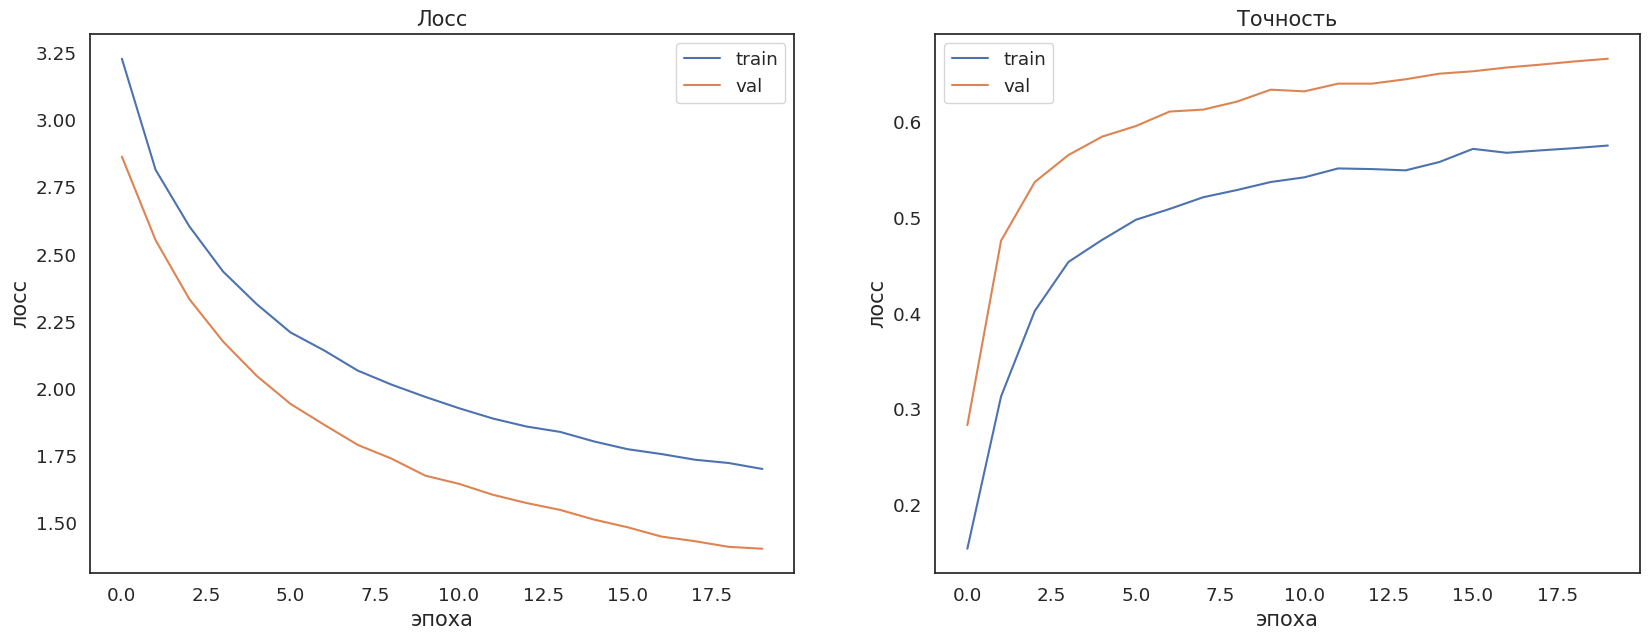

In [ ]:
model = efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

clf_model, history = train(
    model, criterion, optimizer, scheduler,
    train_batch_gen, val_batch_gen,
    num_epochs=20, loss_sched=True
)

## Вывод
В качестве первого эксперимента я взял модель на EfficientNet B0 как Feature Extractor и использовал шедулер ReduceLROnPlateau. Без шедулера я обучал эту архитектуру 10 эпох и качество начало выходить на плато, а точность в конце была 65%. С шедулером я обучил модель на 20 эпохах и она так же не успела выйти на плато, а точность на последней эпохе была 67% (всего на 2% больше, чем без шедулера на 10 эпохах).

Я предполагаю, что прирост в качестве объясняется только прохождением большего числа эпох, так как вероятно модель еще не успела выйти на плато и ошибка на валидации не успела начать увеличиваться, чтобы запустить механизм шедулера ReduceLROnPlateau. По графикам это однозначно нельзя сказать и для оценки эффективности шедулера для этой задачи необходимо обучить модели на значительно большем числе эпох как с шедулером, так и без.

### CosineAnnealingLR и использование `EfficientNet B0` для `Fine Tuning`

Epoch 20 of 20 took 195.727s
  training loss (in-iteration): 	0.213749
  validation loss (in-iteration): 	0.215482
  training accuracy: 			94.55 %
  validation accuracy: 			94.63 %


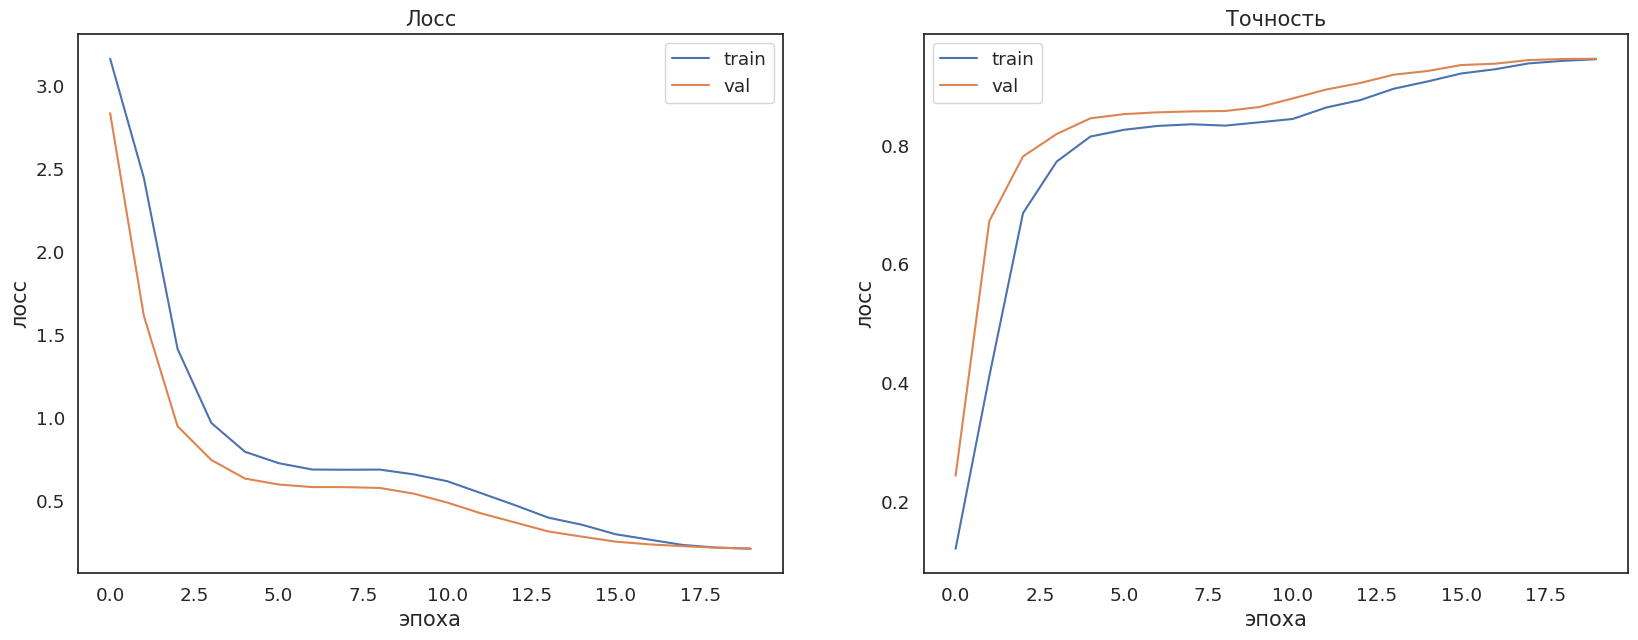

In [ ]:
model = nn.Sequential()
model.add_module('efficientnet', efficientnet_b0(pretrained=True))
model.add_module('relu_1', nn.ReLU())
model.add_module('fc_1', nn.Linear(1000, 512))
model.add_module('relu_2', nn.ReLU())
model.add_module('fc_2', nn.Linear(512, 42))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=7, verbose=True)

clf_model, history = train(
    model, criterion, optimizer, scheduler,
    train_batch_gen, val_batch_gen,
    num_epochs=20, loss_sched=False
)

## Вывод
Во втором эксперименте я взял модель на EfficientNet B0 для Fine Tuning и использовал шедулер CosineAnnealingLR. Аналогично предыдущему эксперименту без шедулера я обучал эту архитектуру 10 эпох, качество так же начало выходить на плато, а точность в конце была 94.30%. С шедулером я обучил модель на 20 эпохах и точность на последней эпохе была 94.63%.

Не могу сказать, что с помощью шедулера удалось достичь прироста в качестве, на мой взгляд он мог скорее помешать модели сойтись к лучшему состоянию за 20 эпох. Это видно по графику оптимизации с шедулером, в нем проявилась некоторая волнообразность. Где-то на 8 эпохе модель уже выходила на плато, но затем видно что в течение нескольких следующих эпох ошибка уменьшалась более интенсивно, а затем снова выходила к состоянию плато ближе к последней 20 эпохе. Это вероятно объясняется волнообразной природой шедулера CosineAnnealingLR, который периодически изменяет learning rate от высоких значений к низким и обратно.

Как и в предыдущем эксперименте, для более однозначной оценки эффективности шедулера для этой задачи необходимо проведение большего числа более длительных исследований. К примеру, следовало бы попробовать запускать шедулер не с первой эпохи, а после того, как модель дейсвтительно выйдет на плато.

# 2. Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.

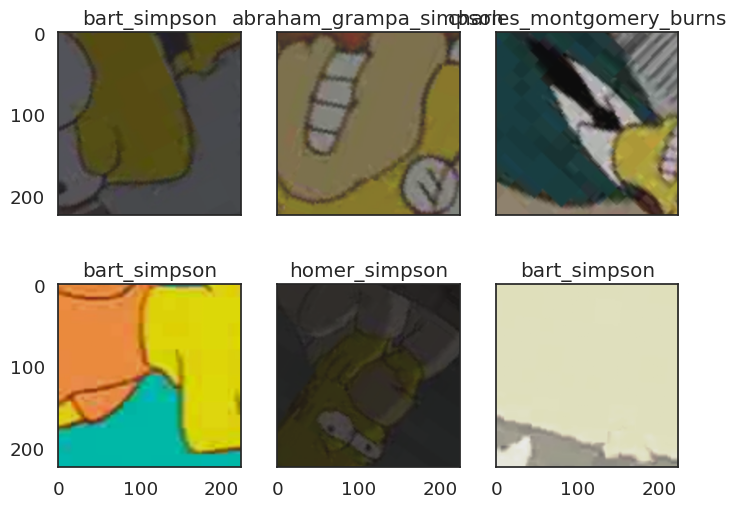

In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.RandomAffine(180),
    transforms.CenterCrop(input_size/2),
    transforms.Resize(input_size),
    transforms.ColorJitter(0.95, 0.95, 0.95),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

show_images(train_dataset)

In [ ]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

Epoch 10 of 10 took 213.642s
  training loss (in-iteration): 	1.744821
  validation loss (in-iteration): 	2.308360
  training accuracy: 			52.73 %
  validation accuracy: 			40.74 %


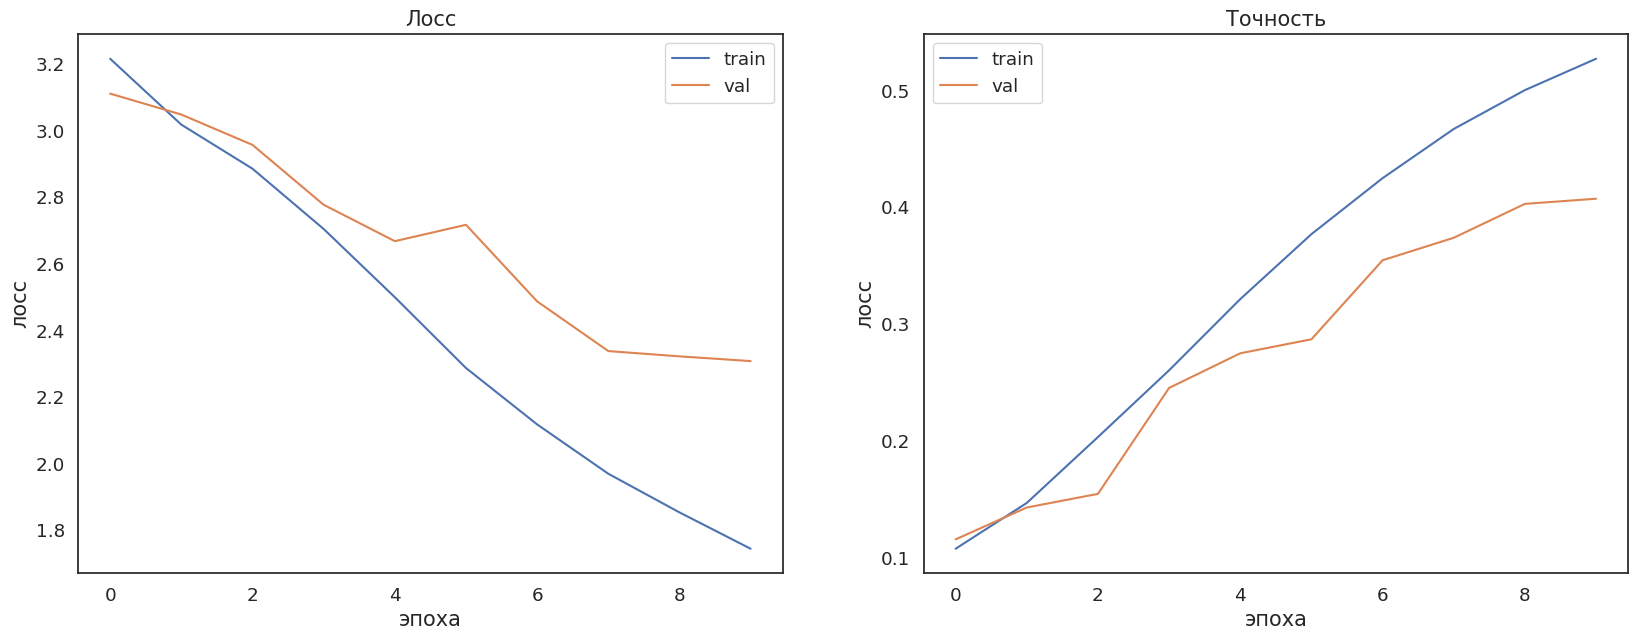

In [ ]:
model = nn.Sequential()
model.add_module('efficientnet', efficientnet_b0(pretrained=True))
model.add_module('relu_1', nn.ReLU())
model.add_module('fc_1', nn.Linear(1000, 512))
model.add_module('relu_2', nn.ReLU())
model.add_module('fc_2', nn.Linear(512, 42))

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10
)

## Выводы
Для эксперимента по снижению качества работы модели я достаточно сильно исказил обучающие данные, включив следующие трансформации в таком порядке:
 - Случайный поворот исходного изображения на +/- 180°
 - Обрезка изображения по центру размером вдвое меньше, чем принимает модель на вход
 - Resize до размера, который модель принимает на вход
 - Изменение цветовых свойств изображения в очень широком диапазоне - ColorJitter(0.95, 0.95, 0.95)

Для обучения я взял метод, показавший себя наилучшим образом в предыдущем задании - использование EfficientNet B0 для Fine Tuning. По истечении 10 эпох точность на валидации достигла лишь 40%, что сильно хуже 94%, которые наблюдались на неискаженных данных, а также хуже всех остальных опробованных методов. На графиках оптимизации видно насколько сильно колеблется качество на валидации и насколько медленно и нестабильно оно улучшается. Также видно, что качество на трейне уже после 2 эпохи превысило валидационное, чего не наблюдалось ни в одном из прежних экспериментов.

Такое поведение должно быть связано с тем, что в результате настолько радикальных транформаций обучающие данные стали слишком не похожи на валидационные, и модель стала гораздо менее эффективно выучивать закономерности, релевантные для исходного датасета.